In [1]:


import string
import re
import itertools

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, rgb2hex
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

from wordcloud import WordCloud, ImageColorGenerator

import networkx as nx

from circos import CircosPlot

import re

In [2]:
data = pd.read_csv('MA-albums_2019-09-14_withFormat.csv', index_col=0, nrows=4000)

In [6]:
data['AlbumLink'][100]

'<a href="https://www.metal-archives.com/albums/Black_Sabbath/Paranoid/485531">Paranoid</a> <!-- 2 -->'

In [3]:
data.head()
#cd='CD'
#vinyl='12" vinyl'
#data.query('Format == @cd',inplace=True)

,BandLink,AlbumLink,Type,Date,CatalogNumber,Format
0,"<a href=""https://www.metal-archives.com/bands/...","<a href=""https://www.metal-archives.com/albums...",Single,1964 <!-- 1964-00-00 -->,4 50 476,"7"" vinyl"
1,"<a href=""https://www.metal-archives.com/bands/...","<a href=""https://www.metal-archives.com/albums...",Split,1964 <!-- 1964-00-00 -->,013533,"7"" vinyl"
2,"<a href=""https://www.metal-archives.com/bands/...","<a href=""https://www.metal-archives.com/albums...",Single,1964 <!-- 1964-00-00 -->,013166,"7"" vinyl"
3,"<a href=""https://www.metal-archives.com/bands/...","<a href=""https://www.metal-archives.com/albums...",Single,1964 <!-- 1964-00-00 -->,4 50 462,"7"" vinyl"
4,"<a href=""https://www.metal-archives.com/bands/...","<a href=""https://www.metal-archives.com/albums...",Single,1964 <!-- 1964-00-00 -->,013168,"7"" vinyl"


In [6]:
def checkSplit(split):
    markedAsAddition = (split.find('(')>-1
        or split.find(')')>-1
        or split.find(',')>-1        
        or split.find('.')>-1     
        or split.find(' ')>-1                          
        or split.find('influenced')>-1
        or not split
    )
    return markedAsAddition

def genreDefinition(longGenre):
    if(longGenre.find('NWOBHM')>-1):
        return 'NWOBHM'
    if(longGenre.find('Thrash')>-1):
        return 'Thrash'
    if(longGenre.find('Hard Rock')>-1 and longGenre.find('Heavy Metal')>-1):
        return 'Heavy'
    if(longGenre.find('Power Metal')>-1):
        return 'Power'
    
    splittedGenre = longGenre.replace('Metal','').replace('metal','').split(' ')

    mainGenrePos=-1
    while checkSplit(splittedGenre[mainGenrePos]):
        mainGenrePos+=-1
    mainGenre = splittedGenre[mainGenrePos]
    mainGenre = mainGenre.split('/')
    mainGenrePos=0
    while checkSplit(mainGenre[mainGenrePos]):
        mainGenrePos+=1
    return mainGenre[mainGenrePos]

def genreSplit(longGenre):
    splits=re.split(' |/|,|\.|;|:|-|with|With',longGenre.replace('Metal','').replace('metal',''))
    splits = [g for g in splits if (g and g.find('(')==-1 and g.find(')')==-1)]
    return splits

In [7]:
gs=genreDefinition('Black Metal (early), Black metal Metal/Noise/Goregrind eins/zwei Rock')

print gs
type(data['AlbumLink'])

Rock


pandas.core.series.Series

In [8]:
from datetime import datetime

startT1=datetime.now()
data_test1=pd.DataFrame()
data_test1['AlbumName']=data['AlbumLink'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser').text)
stopT1=datetime.now()
del data_test1

startT2=datetime.now()
data_test2=pd.DataFrame(index=data.index,columns=['AlbumName'])
for i in data.index:
    data_test2['AlbumName'][i]=BeautifulSoup(data['AlbumLink'][i], 'html.parser').text
data_test2['AlbumName']=data['AlbumLink'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser').text)
stopT2=datetime.now()
del data_test2

deltaT1=stopT1-startT1
deltaT2=stopT2-startT2
print deltaT2-deltaT1

0:00:03.663193


In [3]:
print("start this block")
data_small=pd.DataFrame()
print("parse album names")
data_small['AlbumName']=data['AlbumLink'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser').text)
print('got Album Names')
data_small['BandName']=data['BandLink'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser').text)
print('got Band Names')
#data_small['DateString']=data['Date'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser').text)
data_small['Year']=data['Date'].map(lambda raw_html: int(BeautifulSoup(raw_html, 'html.parser').text.split(' ')[-2]))
data_small['Format']=data['Format']
data_small['Type']=data['Type']
#print('parsed Name and Date, start checking the main Genre')
#data_small['GenreMain']=data['Genre'].map(
#    lambda gen: genreDefinition(gen)
#    )
#data_small['GenreList']=data['Genre'].map(
#    lambda gen: genreSplit(gen)
#    )
n_prev=len(data_small)
print('got ',n_prev,' entries, check for duplicates')
n_woDuplicates=len(data_small.drop_duplicates(['AlbumName','BandName','Year'],inplace=False))
print('There are ',n_prev-n_woDuplicates,' abums as duplicates')
print('save the as csv')
data_small.to_csv('MA-formatsPerYear.csv', encoding='UTF-8')

start this block
parse album names
got Album Names
got Band Names
('got ', 487000, ' entries, check for duplicates')
('There are ', 123710, ' abums as duplicates')
save the as csv


In [15]:
data_small=pd.read_csv('MA-formatsPerYear.csv', index_col=0)

In [14]:
data_small.head()


,AlbumName,BandName,Year,GenreMain,GenreList
0,Shades of Deep Purple,Deep Purple,1968,Heavy,"[Heavy, Hard, Rock]"
2,The Book of Taliesyn,Deep Purple,1968,Heavy,"[Heavy, Hard, Rock]"
3,Ĺ˝elva,Olympic,1968,Heavy,"[Pop, Rock, Heavy, Hard, Rock]"
7,Deep Purple,Deep Purple,1969,Heavy,"[Heavy, Hard, Rock]"
8,Shades of Deep Purple,Deep Purple,1969,Heavy,"[Heavy, Hard, Rock]"


In [5]:
dataAlph=data_small.sort_values('AlbumName')
dataAlph.head()
    


,AlbumName,BandName,Year,Format,Type
257192,! Live ยก Return of the Ancient Demons Fest,Exanime,2012,CD,Live album
304854,!!! Noise Is Protest !!!,Agathocles,2014,Digital,Split
272808,!!! Noise Is Protest !!!,Agathocles,2013,Cassette,Split
17718,!!!Fuck You!!!,Overkill,1987,"12"" vinyl",EP
16248,!!!Fuck You!!!,Overkill,1987,Cassette,EP


In [92]:
all_terms = data_small['GenreMain']      # Flatten terms to a single list
unique_terms, counts = np.unique(all_terms, return_counts=True)          # Get unique terms & counts
genre_terms = pd.DataFrame({'Term': unique_terms, 'TotalCount': counts}) # Store in DataFrame for later
genre_terms.sort_values('TotalCount', ascending=False, inplace=True)     # Sort by count

In [93]:
len(genre_terms)

112

In [60]:
all_terms = data['Genre']      # Flatten terms to a single list
unique_terms, counts = np.unique(all_terms, return_counts=True)          # Get unique terms & counts
genre_terms = pd.DataFrame({'Term': unique_terms, 'TotalCount': counts}) # Store in DataFrame for later
genre_terms.sort_values('TotalCount', ascending=False, inplace=True)     # Sort by count

In [240]:
all_terms = data_small['GenreList']   # Flatten terms to a single list
all_terms_flat=pd.Series([i for j in all_terms for i in j])
#all_terms.apply(pd.Series).stack().reset_index(drop=True)
unique_terms, counts = np.unique(all_terms_flat, return_counts=True)          # Get unique terms & counts
genre_terms_more = pd.DataFrame({'Term': unique_terms, 'TotalCount': counts}) # Store in DataFrame for later
genre_terms_more.sort_values('TotalCount', ascending=False, inplace=True)     # Sort by count
print len(genre_terms_more)
core='core'
genre_terms_more.query('Term==@core')

183


,Term,TotalCount
173,core,2766


In [289]:
print data_small.loc[data_small.index[-1]]['Year']

2019


In [20]:
data_small['Format'].value_counts().values[5:].sum()

25727

In [16]:
data_small['Type'].value_counts()

Full-length      237335
Demo              88321
EP                71847
Single            32775
Split             21480
Compilation       18875
Live album         9531
Video              4789
Boxed set          1162
Collaboration       696
Split video         179
Name: Type, dtype: int64

In [8]:
data_small['Year'].value_counts()

2016    34835
2017    34775
2018    33917
2015    33035
2014    30932
2013    25930
2012    21818
2019    20846
2011    18546
2010    17135
2009    15828
2008    15278
2007    14126
2006    12655
2005    12400
2004    11476
2003    10450
2002    10001
2001     8522
1999     8011
1998     7747
2000     7732
1997     7641
1996     7225
1995     6723
1994     6658
1992     6633
1991     6489
1993     6482
1990     6043
1989     4654
1988     4138
1987     3696
1986     2997
1985     2913
1984     2331
1983     1535
1982     1129
1981      896
1980      752
1979      382
1976      282
1978      255
1977      208
1975      186
1974      157
1973      148
1972      141
1971      125
1970      109
1969       26
1968       20
1965       15
1964        9
1967        4
1966        3
Name: Year, dtype: int64

In [292]:
y85=1985
data_small.query('Year == @y85')['GenreMain'].value_counts()['Heavy']

260

In [10]:
read=False
if(not read):
    yearList=data_small['Year'].value_counts().keys().sort_values()
    FormatList=data_small['Format'].value_counts().keys()
    TypeList=data_small['Type'].value_counts().keys()
    FormatYearCount=pd.DataFrame(0,index=yearList, columns=FormatList)
    TypeYearCount=pd.DataFrame(0,index=yearList, columns=TypeList)
    #GenreYearCount['other']=0
    for y in yearList:
        FormatYearCounts=data_small.query('Year == @y')['Format'].value_counts()
        TypeYearCounts=data_small.query('Year == @y')['Type'].value_counts()
        for i,(g,v) in enumerate(zip(FormatYearCounts.keys(),FormatYearCounts)):
                FormatYearCount[g][y]=v           
                
        for i,(g,v) in enumerate(zip(TypeYearCounts.keys(),TypeYearCounts)):
                TypeYearCount[g][y]=v           
        
    FormatYearCount.to_csv('FormatYearCount.csv')
    TypeYearCount.to_csv('TypeYearCount.csv')
else:
    FormatYearCount = pd.read_csv('FormatYearCount.csv', index_col=0)
    TypeYearCount = pd.read_csv('TypeYearCount.csv', index_col=0)
FormatYearCountNorm=FormatYearCount.apply(lambda x: x/x.sum()*100, axis=1)
TypeYearCountNorm=TypeYearCount.apply(lambda x: x/x.sum()*100, axis=1)
yearSum=pd.DataFrame(data_small['Year'].value_counts())
yearSum.sort_index(inplace=True)

In [77]:
TypeFormatYearCount=dict.fromkeys(TypeYearCount.columns[:5])
yearList=data_small['Year'].value_counts().keys().sort_values()
FormatList=data_small['Format'].value_counts().keys()

for k in TypeFormatYearCount:
    TypeFormatYearCount[k] = pd.DataFrame(0,index=yearList, columns=FormatList)
    for y in yearList:
        tmpFormatYearCounts = data_small.query('Year == @y').query('Type == @k')['Format'].value_counts()
        for i,(g,v) in enumerate(zip(tmpFormatYearCounts.keys(),tmpFormatYearCounts)):
            TypeFormatYearCount[k][g][y]=v

    
#y=1990
#f='Split'
#data_small.query('Year == @y').query('Type == @f')['Format'].value_counts()

In [74]:
for k in TypeFormatYearCount:
    print k
    print TypeFormatYearCount[k].sum()
    print

Split
CD                                        7552
Digital                                   2711
Cassette                                  4537
12" vinyl                                 1590
7" vinyl                                  4196
2CD                                          2
2 12" vinyls                                 0
DVD                                          0
Vinyl                                       44
CD + DVD                                     0
10" vinyl                                   75
VHS                                          1
2 vinyls                                     0
Other                                        0
2DVD                                         0
3CD                                          0
2 cassettes                                  0
2CD + DVD                                    0
12" vinyl + CD                               0
DVD + CD                                     0
3 12" vinyls                                 0
Blu-ray

In [5]:
read=True
if(not read):
    yearList=data_small['Year'].value_counts().keys().sort_values()
    GenreListMore=genre_terms_more['Term']
    GenreYearCountMore=pd.DataFrame(0,index=yearList, columns=GenreListMore)
    GenreYearCountMore['other']=0
    for y in yearList:
        yearCounts=pd.Series([i for j in data_small.query('Year == @y')['GenreList'] for i in j]).value_counts()
        for i,(g,v) in enumerate(zip(yearCounts.keys(),yearCounts)):
            if i < 10 or GenreYearCountMore[g].sum()>0:
                GenreYearCountMore[g][y]=v
            else:
                GenreYearCountMore['other'][y]+=v

    for g in GenreYearCountMore.columns:
        if GenreYearCountMore[g].sum()==0:
            del GenreYearCountMore[g]
    GenreYearCountMore.to_csv('GenreYearCountFlatDef.csv')
else:
        GenreYearCountMore=pd.read_csv('GenreYearCountFlatDef.csv',index_col=0)
GenreYearCountMoreNorm=GenreYearCountMore.apply(lambda x: x/x.sum()*100, axis=1)
smallGenresToClean = ['Gospel', 'Blues', 'Various', 'Pop', 'Punk']
for cl in smallGenresToClean:
    try:
        del GenreYearCountMoreNorm[cl] 
    except:
                pass

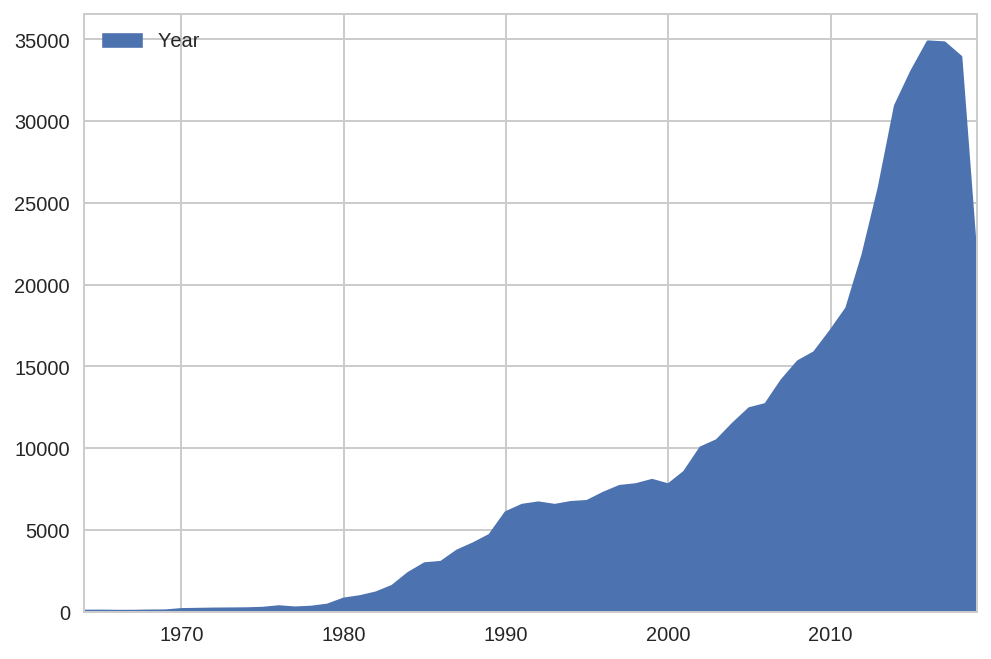

In [11]:
yearSum.plot.area()

In [33]:
TypeYearCountNormClean=TypeYearCountNorm
for c in TypeYearCountNormClean.columns[5:]:
    del TypeYearCountNormClean[c]
    
TypeYearCountClean=TypeYearCount
for c in TypeYearCountClean.columns[5:]:
    del TypeYearCountClean[c]    

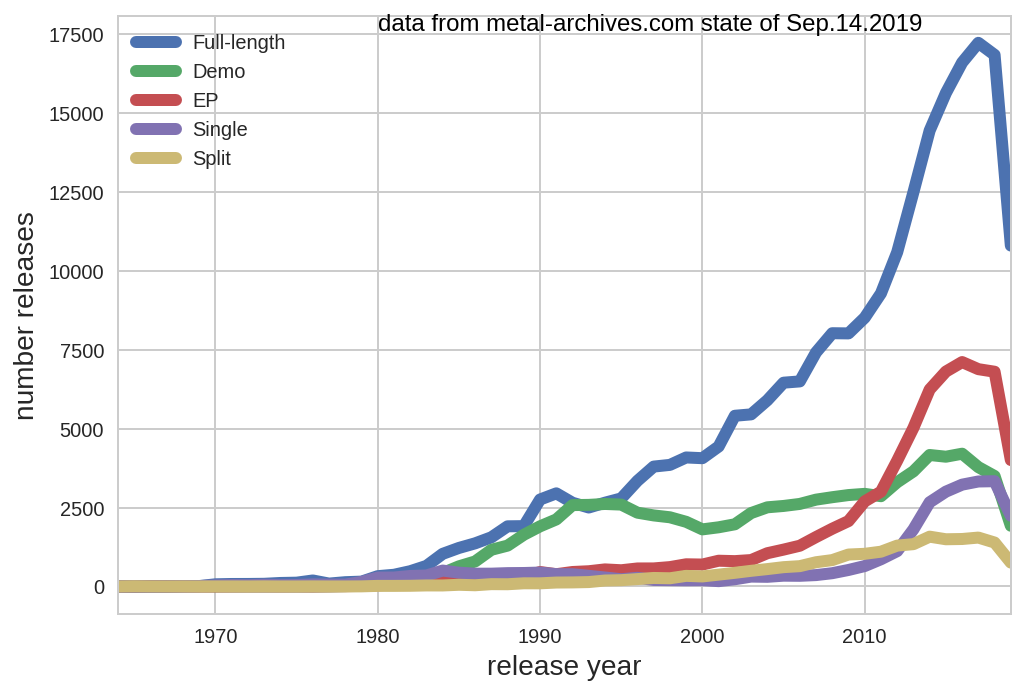

In [47]:
ax=plt.gca()
TypeYearCountClean.plot(ax=ax,linewidth=6)
t1=ax.text(1980,17600,'data from metal-archives.com state of Sep.14.2019',color='k')
ax.set_xlabel('release year', fontsize=14)#
ax.set_ylabel('number releases', fontsize=14)
plt.savefig('TypesPerYear.png',bbox_extra_artists=(t1),dpi=300)

In [27]:
FormatYearCountNormClean=FormatYearCountNorm
for c in FormatYearCountNormClean.columns[5:]:
    del FormatYearCountNormClean[c]
    
FormatYearCountClean=FormatYearCount
for c in FormatYearCountClean.columns[5:]:
    del FormatYearCountClean[c]    

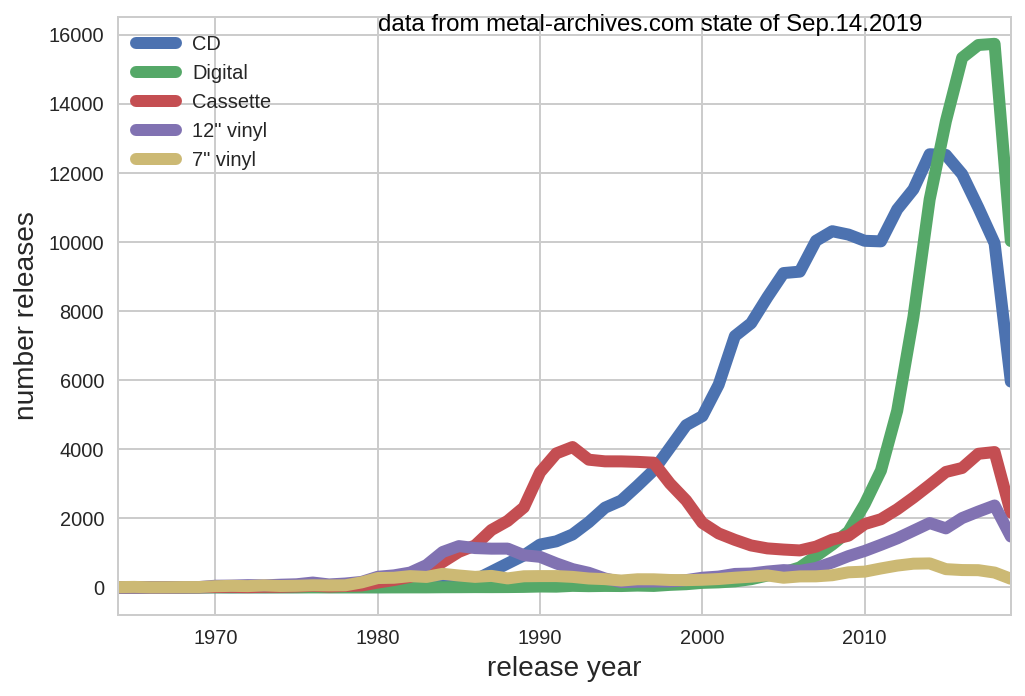

In [45]:
ax=plt.gca()
FormatYearCountClean.plot(ax=ax,linewidth=6)
t1=ax.text(1980,16100,'data from metal-archives.com state of Sep.14.2019',color='k')
ax.set_xlabel('release year', fontsize=14)#
ax.set_ylabel('number releases', fontsize=14)
plt.savefig('FormatsPerYear.png',bbox_extra_artists=(t1),dpi=300)

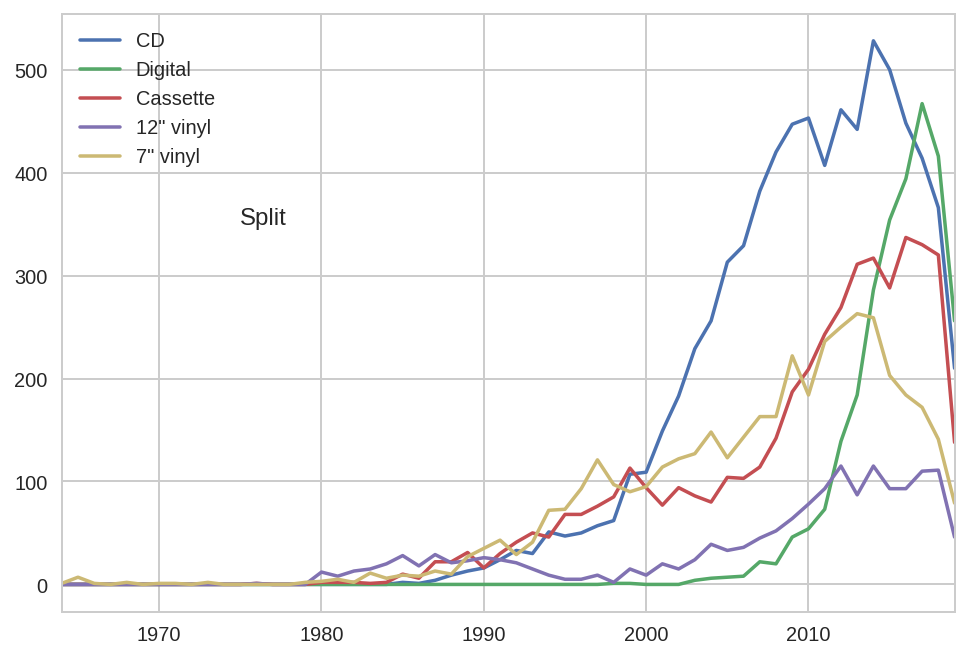

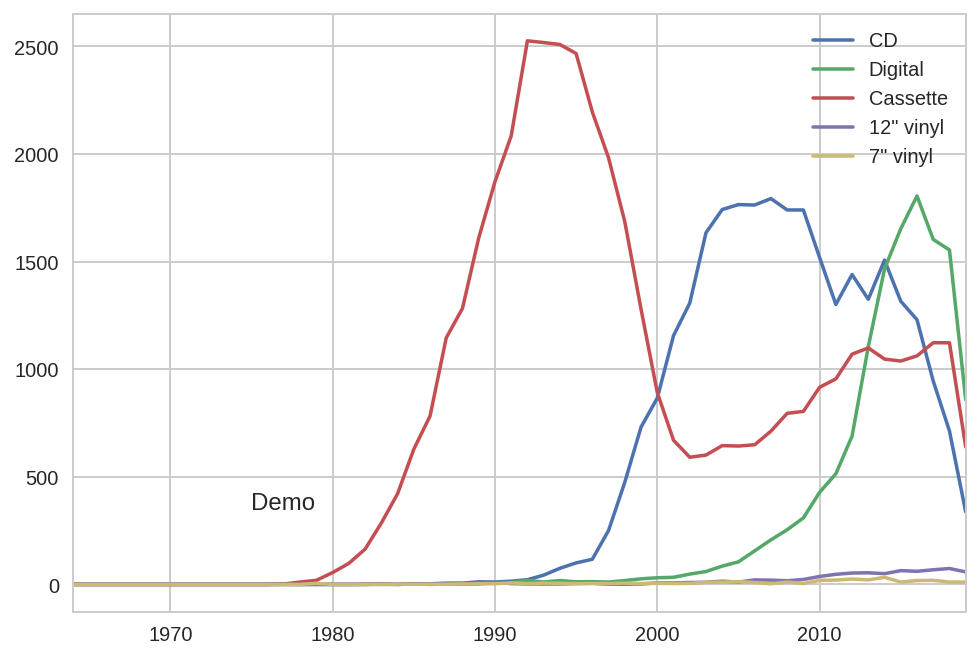

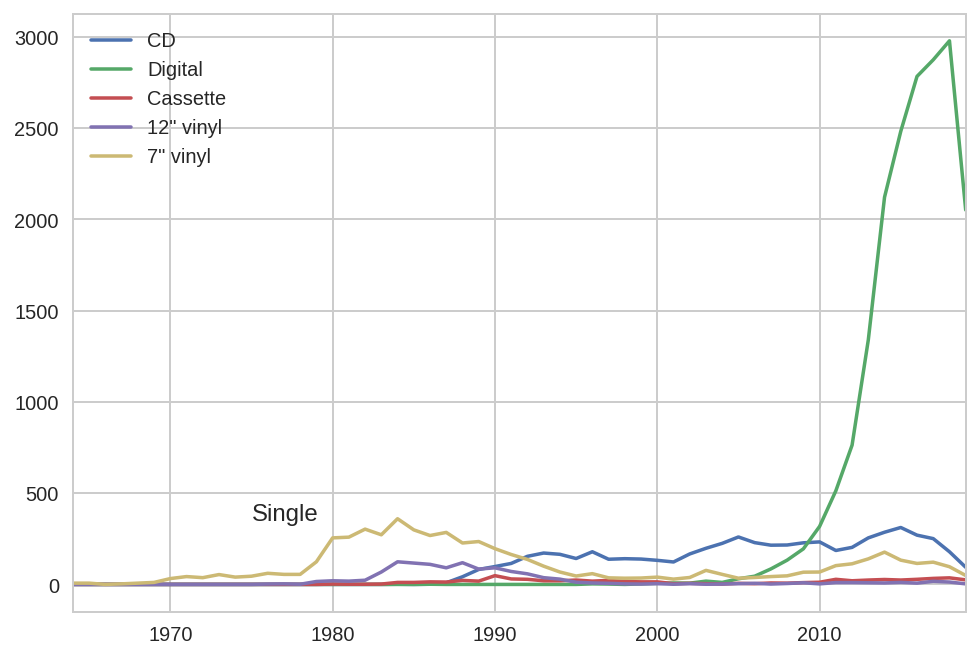

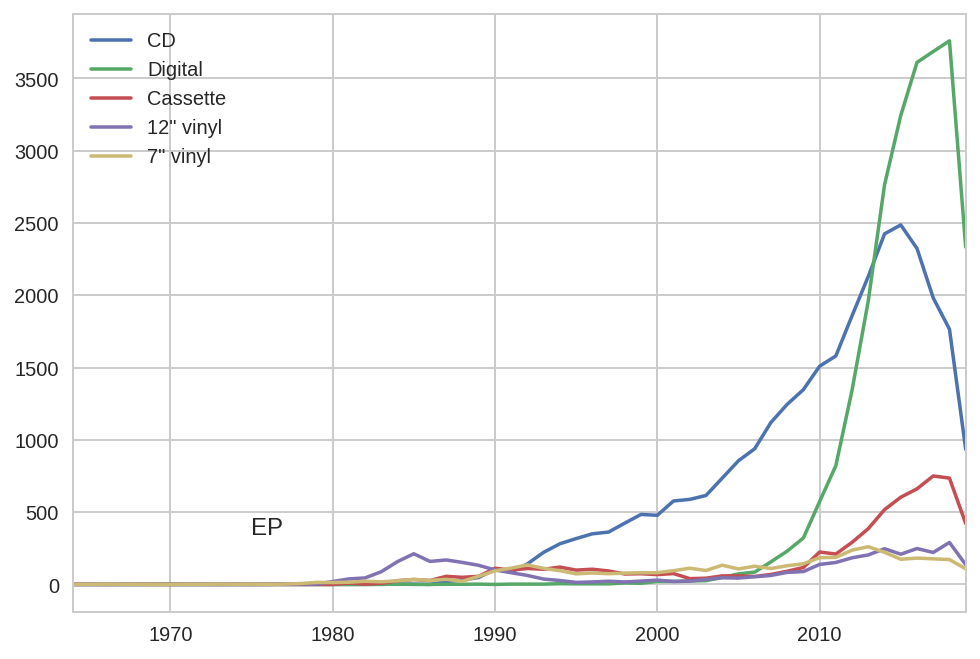

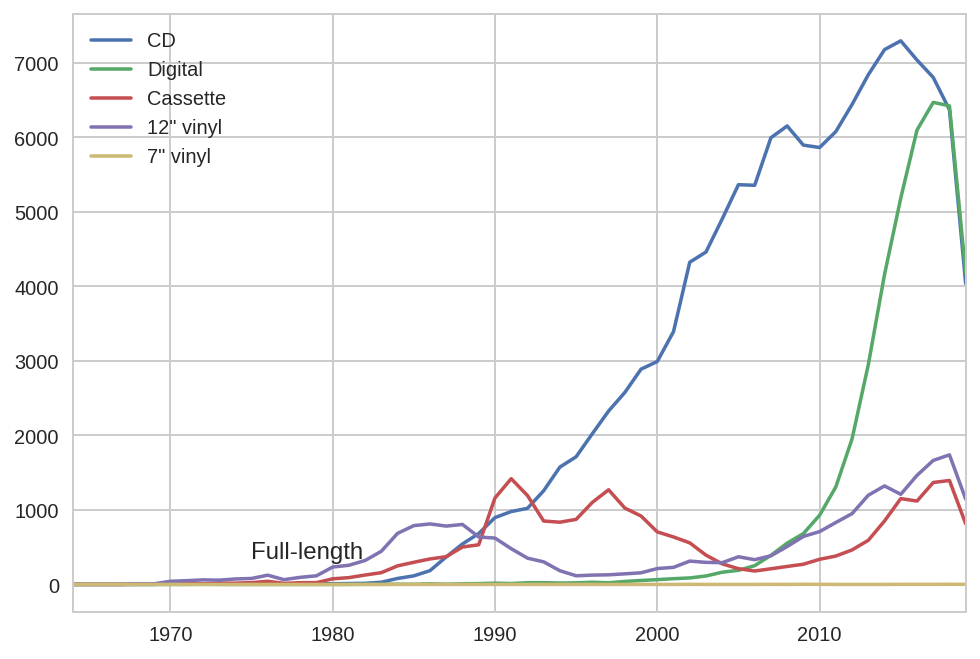

In [82]:


for k in TypeFormatYearCount:
    for c in TypeFormatYearCount[k].columns[5:]:
         del TypeFormatYearCount[k][c]
            
    TypeFormatYearCount[k].plot()
    ax=plt.gca()
    ax.text(1975,350,k)
    plt.savefig('FormatsOf'+k+'.png',dpi=300)

In [335]:
GenreYearCountNorm=GenreYearCount.apply(lambda x: x/x.sum()*100, axis=1)

In [ ]:
yearSum.loc[2019]['Year']

In [9]:
colorsDic={'Death': u'dimgrey','Black':u'black','Power':u'crimson',
           'Gothic':u'olive','Thrash':u'red', 'NWOBHM':u'gold',
           'Rock':u'green','Heavy':u'blue', 'other': 'white', 'Doom':u'lightgoldenrodyellow','Brutal':u'black',
          'Folk':'green' }
badcol = [u'sienna', u'sandybrown', u'bisque', u'blanchedalmond', u'wheat', u'cornsilk',
           u'k', u'w',u'snow',u'd']
from __future__ import division

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
sorted_names.reverse()
sorted_names = [s for s in sorted_names if ((not s in colorsDic.values()) and (not s in badcol) and s.find('gray')<0 and s.find('grey')<0 and s.find('white')<0 )]
sorted_names=sorted_names[0::4]
colors=[]
for key in GenreYearCountMoreNorm.columns:
    if key in colorsDic:
        colors=colors+[colorsDic[key]]
    else:
        colors=colors+[sorted_names.pop()]
        
print colors

[u'dimgrey', u'black', u'blue', u'red', u'green', u'crimson', u'lightgoldenrodyellow', u'rosybrown', u'firebrick', u'mistyrose', u'olive', u'coral', u'chocolate', u'linen', u'black', 'green', u'papayawhip', u'darkgoldenrod', u'palegoldenrod', u'lightyellow', u'yellowgreen', u'gold', u'lawngreen', u'lightgreen', 'white']


start adding Genre tags


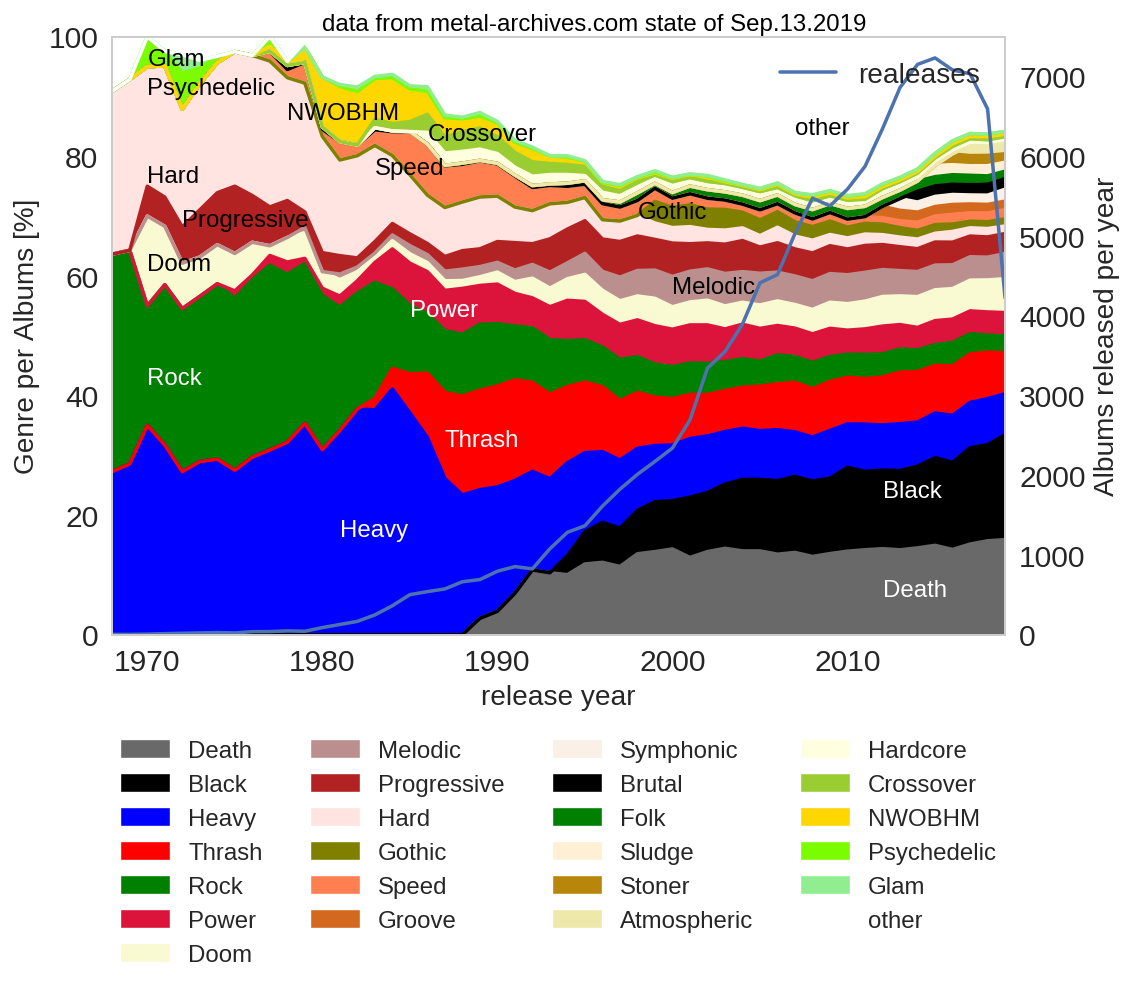

In [14]:
FormatToShow = ['Gospel', 'Blues', 'Various', 'Pop', 'Punk']
for cl in smallGenresToClean:
    try:
        del GenreYearCountMoreNorm[cl] 
    except:
                pass

ax=plt.gca()
#fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
#fig.subplots_adjust(right=0.8)

GenreYearCountMoreNorm.plot.area(ax=axes[0], colors=colors)

#yearSum.loc[2019]['Year']=12./8.5*yearSum.loc[2019]['Year']
yearSum.plot.line(ax=axes[1])
axes[0].plot()
axes[1].plot()
axes[0].set_xlabel('release year', fontsize=14)#
axes[1].set_xlabel('year')
axes[0].set_ylabel('Genre per Albums [%]', fontsize=14)
axes[1].set_ylabel('Albums released per year', fontsize=14)

axes[0].grid(False)
axes[1].grid(False)
axes[0].set_ylim([0,100])
axes[1].set_ylim([0,7500])

axes[0].xaxis.set_tick_params(labelsize=15)
axes[0].yaxis.set_tick_params(labelsize=15)
axes[1].yaxis.set_tick_params(labelsize=15)

lgd1=axes[1].legend(loc='upper right',labels=['realeases'], prop={'size': 14})
lgd2=axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), ncol=4, prop={'size': 12})

yOffsetsum = 0.
color='w'
print 'start adding Genre tags'
for name in GenreYearCountMoreNorm.columns:
    if name=='Doom':
        color='k'
    locx = GenreYearCountMoreNorm[name].idxmax()  
    locy = GenreYearCountMoreNorm[name][locx]
    if locy<3.:
        continue
    axes[0].text(max(min(2015,locx)-3,1970),GenreYearCountMoreNorm.loc[locx,:name].sum()-(locy*0.6),name, color=color)

t1=axes[0].text(1980,101,'data from metal-archives.com state of Sep.13.2019',color='k')

plt.savefig('outputGenreSplits.png', bbox_extra_artists=(lgd1,lgd2,t1), bbox_inches='tight', dpi=300)

In [257]:
GenreYearCountMoreNorm.loc[2018,:'Thrash'].sum()


Term
Death     15.704616
Black     16.069663
Heavy      7.704008
Thrash     7.772454
Name: 2018, dtype: float64

ax=plt.gca()
#fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
#fig.subplots_adjust(right=0.8)

GenreYearCountNorm.plot.area(ax=axes[0], colors=['k','gray','b','g','r',
                                                  'lightblue','w','darkviolet','olive','c','y','m',
                                                'tab:blue','tab:orange','tab:brown','tab:pink','tab:red','tab:green','wheat'])
yearSum.plot.line(ax=axes[1])
axes[0].plot()
axes[1].plot()
axes[0].set_xlabel('year')#
axes[1].set_xlabel('year')
axes[0].set_ylabel('Genre per Albums [%]')
axes[1].set_ylabel('Albums released per year')

plt.savefig('outputLongGenre.png')

In [174]:
a=[1,2,3,4]
a.reverse()
a.pop()
a

[4, 3, 2]